In [1]:
from vampyr import vampyr3d as vp
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy.integrate as integrate
from scipy.special import legendre, laguerre, erf, gamma
from scipy.special import gamma
from scipy.constants import hbar

mra = vp.MultiResolutionAnalysis(box=[-20,20], order=7)
prec = 1.0e-4

print(mra)
help(vp.ScalingProjector)

                    MultiResolution Analysis                    
----------------------------------------------------------------
 polynomial order      : 7
 polynomial type       : Interpolating
----------------------------------------------------------------
 total boxes           : 8
 boxes                 : [          2           2           2 ]
 unit lengths          : [  20.000000   20.000000   20.000000 ]
 scaling factor        : [   1.250000    1.250000    1.250000 ]
 lower bounds          : [ -20.000000  -20.000000  -20.000000 ]
 upper bounds          : [  20.000000   20.000000   20.000000 ]
 total length          : [  40.000000   40.000000   40.000000 ]

Help on class ScalingProjector in module vampyr._vampyr.vampyr3d:

class ScalingProjector(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      ScalingProjector
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(...)
 |      __call__(*args, **kw

0.6613878614971826 -5583.9425981964805


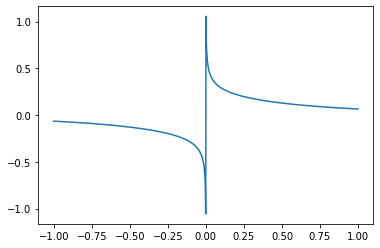

In [2]:
# H atom (almost) according to wikipedia
# Normalization not considered
# Exponential coeffcient C=1 (wikipedia coeff is not compatible with eigensolution)
# Limited to ground state for now (some formulas are however more generic)
# So far the best general description for the 4-c H atom was in the Bethe&Salpeter book

c=137.035999
alpha = 1.0/c
k = -1
l = 0
n = 1
m = 0.5
Z = 92

def compute_gamma(k,Z,alpha):
    return np.sqrt(k**2 - Z**2 * alpha**2)

def compute_dirac_energy(n,Z,k,alpha):
    gamma_factor = compute_gamma(k,Z,alpha)
    tmp1 = n - np.abs(k) + gamma_factor
    tmp2 = Z * alpha / tmp1
    tmp3 = 1 + tmp2**2
    return c**2 / np.sqrt(tmp3)
#
# Approx expression
#
#def compute_dirac_energy(n,Z,k,c):
#    tmp1 = 1.0/np.abs(k) - 3.0/(4*n)
#    tmp2 = 1 + tmp1 * Z**2 / (n * c**2)
#    return c**2 - tmp2 * Z**2 / (2*n**2)


def compute_norm_const(n, gamma_factor):
# THIS NORMALIZATION CONSTANT IS FROM WIKIPEDIA BUT IT DOES NOT AGREE WITH Bethe&Salpeter
    tmp1 = 2 * n * (n + gamma_factor)
    tmp2 = 1 / (gamma_factor * gamma(2 * gamma_factor))
    return np.sqrt(tmp2/tmp1)

def one_s_alpha(x,Z,alpha,gamma_factor):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    tmp1 = 1.0 + gamma_factor
    tmp4 = Z * alpha
    u = x/r
    lar =   tmp1
    sai =   tmp4 * u[2]
    sbr = - tmp4 * u[1]
    sbi =   tmp4 * u[0]
    return lar, 0, 0, 0, 0, sai, sbr, sbi

def one_s_alpha_comp(x,Z,alpha,gamma_factor,norm_const,comp):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    tmp2 = r ** (gamma_factor - 1)
    tmp3 = np.exp(-r)
    values = one_s_alpha(x,Z,alpha,gamma_factor)
    return values[comp] * tmp2 * tmp3 * norm_const / np.sqrt(2*np.pi)
                
gamma_factor = compute_gamma(k,Z,alpha)
norm_const = compute_norm_const(n, gamma_factor)
energy = compute_dirac_energy(n,Z,k,alpha)
Ezora = 2*(energy-c**2)*c**2/(energy+c**2)
print(norm_const,Ezora)

x_plt = np.linspace(-1.0, 1.0, 1000)
y_plt = [one_s_alpha_comp([x,0.0,0.0],Z,alpha,gamma_factor,norm_const,7) for x in x_plt]
_ = plt.plot(x_plt, y_plt)

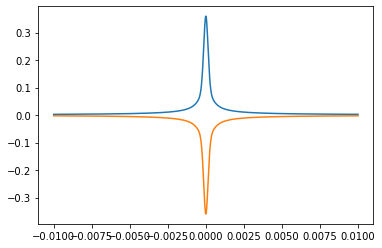

In [3]:
def u(r):
    u = erf(r)/r + (1/(3*np.sqrt(np.pi)))*(np.exp(-(r**2)) + 16*np.exp(-4*r**2))
    #erf(r) is an error function that is supposed to stop the potential well from going to inf.
    #if i remember correctly
    return u

def V(x):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
#    c = 0.0435
    c = 0.000435 # ten times tighter nuclear potential
    f_bar = u(r/c)/c
    return f_bar

def kappa(x):
    temp = V(x) / (2 * c**2)
    return 1.0/(1-temp)

def one_m_kappa(x):
    temp = (2 * c**2) / V(x)
    return 1.0/(1-temp)

x_plt = np.linspace(-0.01, 0.01, 1000)
y1_plt = [kappa([x, 0.0, 0.0])-1 for x in x_plt]
y2_plt = [one_m_kappa([x, 0.0, 0.0]) for x in x_plt]
plt.plot(x_plt, y1_plt)
plt.plot(x_plt, y2_plt)

In [ ]:
Peps = vp.ScalingProjector(mra,prec)
f = lambda x:V([x[0]-origin[0],x[1]-origin[1],x[2]-origin[2]])
V_tree = Peps(f)

In [5]:
help(vp.ScalingProjector)

Help on class ScalingProjector in module vampyr._vampyr.vampyr3d:

class ScalingProjector(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      ScalingProjector
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(...)
 |      __call__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __call__(self: vampyr._vampyr.vampyr3d.ScalingProjector, func: mrcpp::RepresentableFunction<3>) -> mrcpp::FunctionTree<3>
 |      
 |      2. __call__(self: vampyr._vampyr.vampyr3d.ScalingProjector, func: Callable[[List[float[3]]], float]) -> mrcpp::FunctionTree<3>
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: vampyr._vampyr.vampyr3d.ScalingProjector, mra: mrcpp::MultiResolutionAnalysis<3>, prec: float) -> None
 |      
 |      2. __init__(self: vampyr._vampyr.vampyr3d.ScalingProjector, mra: mrcpp::MultiResolutionAnalysis<3>, scale: int)